# Weighted Averages and Measurement Uncertainties

### Goals:

1. To review simple statistics, the mean and standard deviation.
2. To understand a new statistic, the variance, and why it is so useful.
3. To understand why using the inverse of the variance to do weighted averages, (i,e., "inverse variance weighting") is the standard way to combine measurements that have different uncertainties.

### Timing

1. Try to finish this notebook in 30-35 minutes

### Question and Answer Template

You can go to the link below, and do "file" -> "make a copy" to make yourself a google doc that you can use to fill in the answers to the question in this weeks notebooks.

https://docs.google.com/document/d/1uNPXYCd6IF-jAnPyq7k9pFP2x7VIohZZstGqm6t0WC8/edit?usp=sharing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### New functions we will use in this module

| Function Name            | What it does |
| - | - |
| numpy.var                | Compute the variance of the values in an array |
| numpy.random.normal      | Generate random numbers from a normal or 'Gaussian' distribution |
| array.size               | return the number of elements in an array |
| array.shape              | return the shape of an array, i.e., arrays have more that one dimension and this function tells you the shape of the array.  The size of the array is the product of the size of all the axes of the array |
| plt.errorbar             | make a plot with error bars |
| plt.legend               | add a legend to a figure |

### Formulas

mean = $\frac{\sum_i x_i}{n}$

weighted mean = $\frac{\sum_i w_i * x_i}{\sum w_i}$

# Loading Hubble measurement results

Let's re-use the cell from last week where we loaded the Hubble measurements.

In [2]:
data = np.loadtxt(open("../data/Hubble.txt", 'rb'), usecols=[1,2,3])
# This is how we pull out the data from columns in the array.
H0_measured = data[:,0]
H0_errorLow = data[:,1]
H0_errorHigh = data[:,2]
N_measurements = H0_measured.size

#### Histogramming the results

Here is a histogram of the results.  Note that we have expanded the x-axis.  You will see why in a few cells.

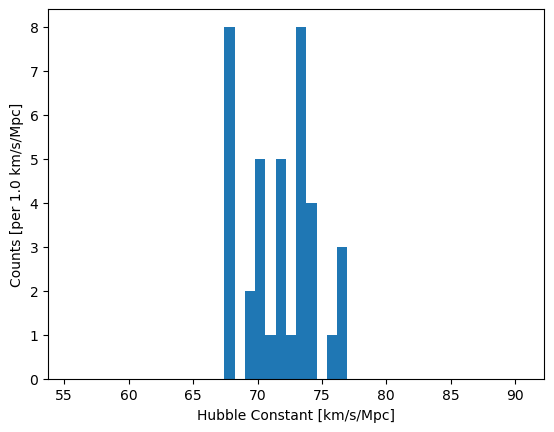

In [3]:
plt.hist(H0_measured, bins=np.linspace(55.5, 90.5, 45))
plt.xlabel("Hubble Constant [km/s/Mpc]")
plt.ylabel("Counts [per 1.0 km/s/Mpc]")
plt.show()

### Adding measurement errors.

Now let's plot the measurements with error bars to visualize the uncertainty.

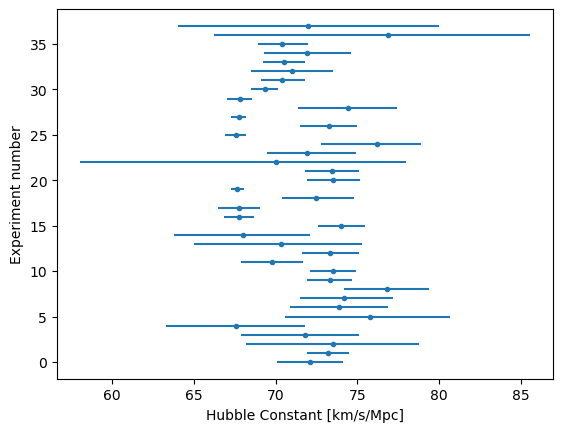

In [4]:
plt.errorbar(H0_measured, np.arange(N_measurements), xerr=(H0_errorLow, H0_errorHigh), fmt=".")
plt.xlabel("Hubble Constant [km/s/Mpc]")
plt.ylabel("Experiment number")
plt.show()

### Questions for discussion

#### 1.1 What do we learn from the figure with the error bars included as opposed to the histogram?  Does it change your estimate of what the true value of the Hubble parameter is?  

#### 1.2 There is no single true value that is consistent with all (or even most) of the measured values within the errors.  I.e., there is no value along the x-axis that we could draw a vertical line from that would go through all the error bars.  What do you think that means?  

#### 1.3 Before proceeding, describe a way that you might derive an estimate of the true value of the Hubble parameter (and an uncertainty on that value) that uses both the measured values and their stated uncertainties.  


## Review from last week: quantifying the scatter of data.

Recall that last week we explored a number of different ways to quantify the scatter in data.

The last two that we discussed were the "standard deviation" and "standard error".

The "standard deviation" tells use how much intrisict scatter there is in the data. It is equivalent to the RMS (root-mean-square) of a dataset with a mean of 0.

The "standard error" accounts for the fact that if we keep measuring something, and the measurements keep falling within the same range, that actually gives us a better estimate of what the true value is, because we are averaging out the statistical fluctuations. It is also known as the standard error on the mean because it quantifies the uncertainty on the calculated mean of a large number of measurements.

The formula for these are:

average:            $ \mu = \frac{\sum_i x_i}{n}$

standard deviation: $ \sigma = (\frac{\sum_i (x_i - \mu)^2}{n})^{1/2} $

standard error:     $ \frac{\sigma}{\sqrt{n}}$

## The "variance", an extremely useful quantity.  

The "variance" of a distribution is the square of the standard deviation, and it has a number of useful properties that we will explore later in this course.  For now I'm just going to write down the equation.

variance : $\sigma^2 = \frac{\sum_i (x_i - \mu)^2}{n}$

In [5]:
variance = np.var(H0_measured)
variance_check = np.std(H0_measured)**2
print("Variance:       ", variance)
print("Variance check: ", variance_check)

Variance:        7.427827770083109
Variance check:  7.42782777008311


In [6]:
# This will throw an error if these values aren't close!
assert np.isclose(variance, variance_check)

# Simulating data from a bell curve 

## (a.k.a. a "Gaussian" or "Normal" distribution)

We will be discussing the "Gaussian" or "Normal" distribution a lot more in coming weeks.  

For now let's just state that in many cases a normal distribution is a good representation the sort of random variations you expect to see in data if you perform a measurement many times. It is parameterized by μ and σ, which represent the mean and the standard deviation of the data. The [wikipedia page](https://en.wikipedia.org/wiki/Normal_distribution) gives a good summary.

The function `rng.normal` will generate values from a Gaussian distribution. Let's generate a Gaussian with $\mu$ equal to mean and $\sigma$ equal to the standard deviation of the Hubble measurements. 

In [7]:
rng = np.random.default_rng(42) # choose 42 as seed

In [8]:
# help(rng.normal) # uncomment for help!

In [9]:
N_measurements = len(H0_measured)
H0_mean = np.mean(H0_measured)
H0_std = np.std(H0_measured)
H0_err = H0_std / np.sqrt(N_measurements)

# This prints values using python's f-strings
print(f"H0 = {H0_mean:0.3f} ± {H0_err:0.3f}")  # use :0.3f to get 3 decimals from the float number

H0 = 71.713 ± 0.442


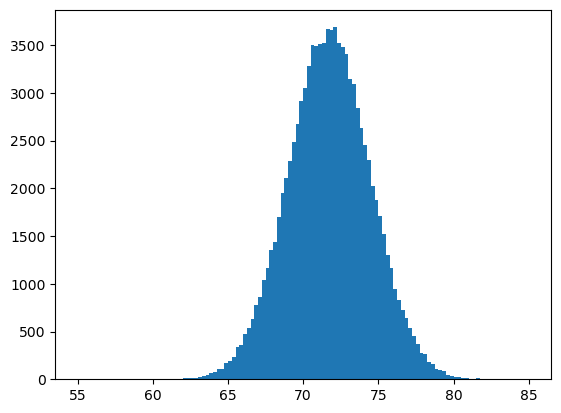

In [10]:
simData = np.random.normal(loc=H0_mean, scale=H0_std, size=100000)
plt.hist(simData, bins=np.linspace(55., 85., 121))
plt.show()

### Simulating a bunch of measurements of the Hubble constant

Now we are going to pretend that we sent out 5 teams of scientists, and asked each of them to do some measurements of the Hubble constant, and that **all the measurements are drawn from the Gaussian distribution above**.  Each team performs a different number of measurements, but in total they have 100 measurements.

We are then going to consider two different ways of combining their results.

1. Taking the overall mean and error on the mean from all 100 measurements.
2. Taking the mean and the error on the mean from each group of scientists, and making a weighted average.

In [11]:
dataSample_0 = rng.normal(loc=H0_mean, scale=H0_std, size=50)
dataSample_1 = rng.normal(loc=H0_mean, scale=H0_std, size=3)
dataSample_2 = rng.normal(loc=H0_mean, scale=H0_std, size=27)
dataSample_3 = rng.normal(loc=H0_mean, scale=H0_std, size=2)
dataSample_4 = rng.normal(loc=H0_mean, scale=H0_std, size=18)
dataSamples = [dataSample_0, dataSample_1, dataSample_2, dataSample_3, dataSample_4]
mergedSample = np.hstack(dataSamples)

### Now we are going to use numpy to do some statistics for us

Pro-tip: python gives you a shortcut for writing out loops

for example `[np.mean(dataSample) for dataSample in dataSamples]` tells python 

1. loop over all the elements in the list of dataSamples
2. for each element to take the mean
3. add that mean onto a list

This construction is called "list comprehension" and is used a lot by python programmers.

In [12]:
means = np.array([np.mean(dataSample) for dataSample in dataSamples])
stds = np.array([np.std(dataSample) for dataSample in dataSamples])
errors = np.array([np.std(dataSample)/np.sqrt(len(dataSample)) for dataSample in dataSamples])
for mean, err in zip(means, errors):
    print(f"Value = {mean:0.2f} ± {err:0.2f}")

Value = 71.96 ± 0.29
Value = 71.23 ± 1.44
Value = 71.51 ± 0.40
Value = 71.43 ± 1.08
Value = 70.67 ± 0.46


### Now let's plot the summary results that each group of scientists might report

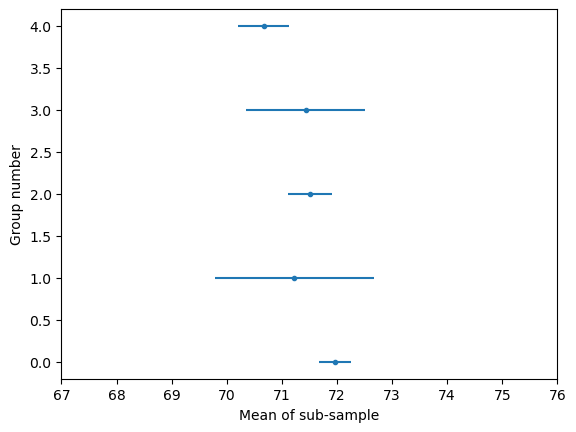

In [13]:
plt.errorbar(means, np.arange(len(means)), xerr=(errors), fmt=".")
plt.xlim(67.,76.)
plt.xlabel("Mean of sub-sample")
plt.ylabel("Group number")
plt.show()

### Questions for discussion: 

#### 2.1 Even though all of the measurements are being simulated from the same distribution, the different groups of scientists are reporting different uncertainties for their best estimates.  Why is that?

### Combining the scientists' measurements

If all of the scientists were open with their data, we could just aggregate the data and calculate the mean and error using the aggregate sample:

In [14]:
overall_mean  = np.mean(mergedSample)
overall_std   = np.std(mergedSample)
overall_error = np.std(mergedSample) / np.sqrt(len(mergedSample))
print(f"Mean:  {overall_mean:0.3f} ± {overall_error:0.3f}")

Mean:  71.576 ± 0.211


In science, often different groups of scientists measure the same parameter through different approaches/instruments, or don't directly work together. So in this case, it's not straightforward to combine all of the measurements and take the mean. Instead, we only have the mean and error reported from each group. 

Let's combine the reports from the scientists in two ways: 
- using a "straightforward" mean (i.e. the formula that we have been using for the mean), and
- using a weighted mean, where each mean is divided by the variance of that measurement.

In [15]:
straight_mean = np.mean(means)
straight_error = np.std(means)/np.sqrt(len(means))

weights        = 1./(errors*errors)
weighted_mean  = np.sum(means*weights)/np.sum(weights)
weighted_error = np.sqrt(1/np.sum(weights))

print(f"Straight mean: {straight_mean:0.3f} ± {straight_error:0.3f}")
print(f"Weighted mean: {weighted_mean:0.3f} ± {weighted_error:0.3f}")
print(f"Truth        : {H0_mean:0.3f}")

Straight mean: 71.362 ± 0.188
Weighted mean: 71.558 ± 0.204
Truth        : 71.713


###  Now let's add those to our plot

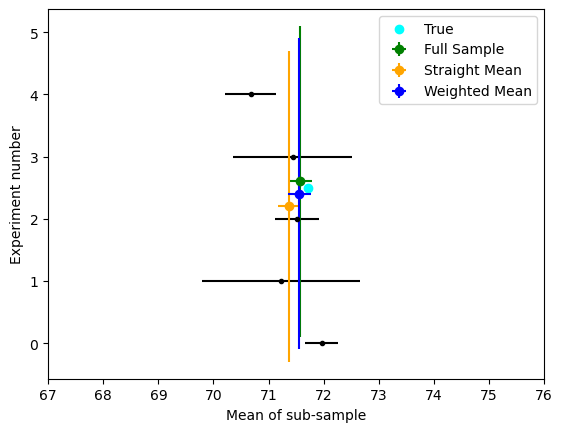

In [16]:
plt.errorbar(means, np.arange(len(means)), xerr=(errors), fmt=".", color='black')
plt.xlim(67, 76)
plt.xlabel("Mean of sub-sample")
plt.ylabel("Experiment number")
plt.errorbar(overall_mean, 2.6, xerr=overall_error, yerr=2.5, fmt='o', color='green', label="Full Sample")
plt.errorbar(straight_mean, 2.2, xerr=straight_error, yerr=2.5, fmt='o', color='orange', label="Straight Mean")
plt.errorbar(weighted_mean, 2.4, xerr=weighted_error, yerr=2.5, fmt='o', color='blue', label="Weighted Mean")
plt.scatter(H0_mean, 2.5, marker='o', color='cyan', label="True")
plt.legend()
plt.show()

### Questions for discussion:

#### 3.1 In your own words, describe what is being presented in the previous plot and the two cells before that.

#### 3.2 In this case, the different methods of combining the results give quite similar, but not identical, final answers.   Do you think that the results are "consistent enough"?  I.e., do they seem to agree within their reported errors?

#### 3.3 The usual convention for combining results is to use variance weighting (i.e., the weighted mean as computed here).  Does that seem like a sensible convention to you?  Why or why not?

### Now let's try the using the uncertainties to get a weighted average of the Hubble measurements

Now we can go back to the real Hubble data, and combine the measurements!

In [17]:
H0_errors = H0_errorLow + H0_errorHigh
H0_weights = 1./(H0_errors*H0_errors)

H0_wmean  = np.sum(H0_measured*H0_weights)/np.sum(H0_weights)
H0_werror = np.sqrt(1/np.sum(H0_weights))

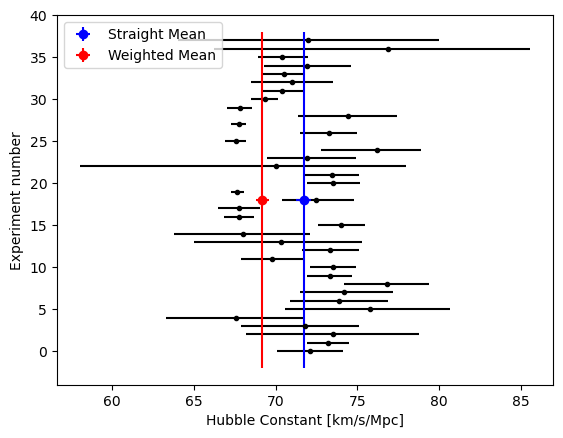

In [18]:
plt.errorbar(H0_measured, np.arange(N_measurements), xerr=(H0_errorLow, H0_errorHigh), fmt=".", color='k')
plt.xlabel("Hubble Constant [km/s/Mpc]")
plt.ylabel("Experiment number")
plt.errorbar(H0_mean, 18, xerr=H0_err, yerr=20, fmt='o', color='b', label="Straight Mean")
plt.errorbar(H0_wmean, 18, xerr=H0_werror, yerr=20, fmt='o', color="r", label="Weighted Mean")
plt.legend()
plt.show()

### Questions for discussion:

#### 4.1 In this case the weighted mean doesn't quite agree with the straight mean.  Looking at the plot, why do you think that is?

#### 4.2 Does this change what you think about what the best estimate of the Hubble parameter might be?  Why?  What about the uncertainty on the Hubble parameter?